In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import itertools

In [2]:
data_path = "/home/davidchan/Projects/random-needles/outputs/exps/contextual/coin_flip_icl_double_dist/meta-llama_Llama-3.1-8B-Instruct/icl_{icl}/cutoff_{cutoff}/bias_{bias_1}_{bias_2}/stats.json"
def load_data(icl, cutoff, bias_1, bias_2):
    with open(data_path.format(icl=icl, cutoff=cutoff, bias_1=bias_1, bias_2=bias_2)) as f:
        data = json.load(f)

    cutoff_ratio = float(data['cutoff']) / float(data['icl_len'])
    data['expected_dist'] = cutoff_ratio * float(data['bias_1']) / 100 + (1 - cutoff_ratio) * float(data['bias_2']) / 100
    return data

In [ ]:
load_data(100, 10, 0, 80)['all_attentions'][0][1].keys()

dict_keys(['attention', 'tokens'])

In [4]:
cutoffs = [10, 20, 30, 40, 50, 60, 70, 80, 90]
biases = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

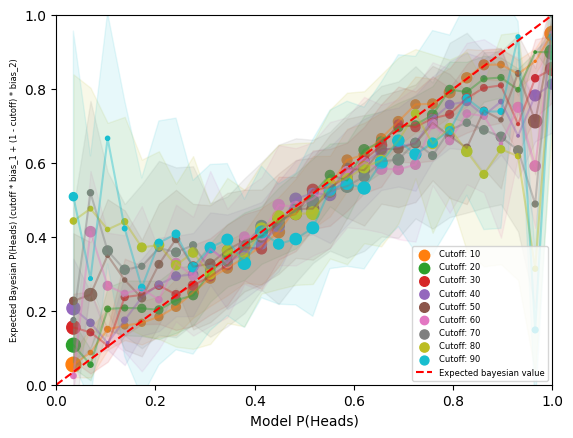

In [5]:

for i, cutoff in enumerate(cutoffs):
    data_x = []
    data_y = []
    for bias_1 in biases:
        for bias_2 in biases:
            try:
                data = load_data(100, cutoff, bias_1, bias_2)
            except FileNotFoundError:
                continue

            # Get the true distribution
            points = [p['choice_probs'][0] for p in data['all_probs']]
            data_x.extend(points)
            data_y.extend([data['expected_dist']] * len(points))

    if not data_x:
        continue

    # Bucket the data points to make the plot more readable
    data_x = np.array(data_x)
    data_y = np.array(data_y)
    bins = np.linspace(0, 1, 30)
    digitized = np.digitize(data_x, bins)

    bin_means = [data_y[digitized == i].mean() for i in range(1, len(bins))]
    bin_stds = [data_y[digitized == i].std() for i in range(1, len(bins))]
    bin_counts = [np.sum(digitized == i) for i in range(1, len(bins))]
    bin_means = np.array(bin_means)
    bin_counts = np.array(bin_counts)

    # Get the color
    color = plt.cm.tab10(i+1)

    plt.scatter(bins[1:], bin_means, s=bin_counts, label=f'Cutoff: {cutoff}', alpha=1, color=color)
    plt.plot(bins[1:], bin_means, alpha=0.4, color=color)
    plt.fill_between(bins[1:], bin_means - bin_stds, bin_means + bin_stds, alpha=0.1, color=color)


plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Expected bayesian value')
plt.legend(fontsize=6)
plt.xlabel('Model P(Heads)')
plt.ylabel('Expected Bayesian P(Heads) (cutoff * bias_1 + (1 - cutoff) * bias_2)', fontsize=6)
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()

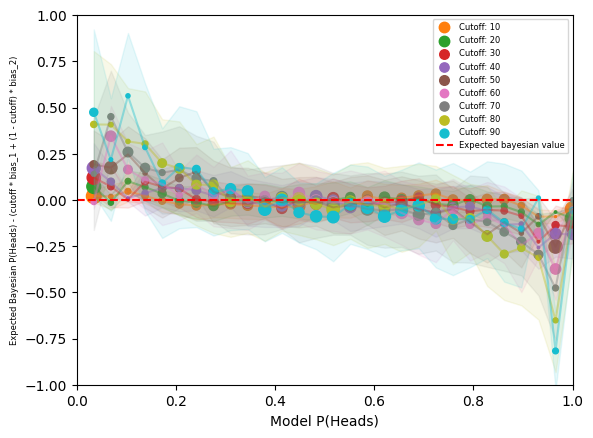

In [6]:

for i, cutoff in enumerate(cutoffs):
    data_x = []
    data_y = []
    for bias_1 in biases:
        for bias_2 in biases:
            try:
                data = load_data(100, cutoff, bias_1, bias_2)
            except FileNotFoundError:
                continue

            # Get the true distribution
            points = [p['choice_probs'][0] for p in data['all_probs']]
            data_x.extend(points)
            data_y.extend([data['expected_dist']] * len(points))

    if not data_x:
        continue

    # Bucket the data points to make the plot more readable
    data_x = np.array(data_x)
    data_y = np.array(data_y)
    bins = np.linspace(0, 1, 30)
    digitized = np.digitize(data_x, bins)

    bin_means = [data_y[digitized == i].mean() for i in range(1, len(bins))]
    bin_stds = [data_y[digitized == i].std() for i in range(1, len(bins))]
    bin_counts = [np.sum(digitized == i) for i in range(1, len(bins))]
    bin_means = np.array(bin_means)
    bin_counts = np.array(bin_counts)

    # Get the color
    color = plt.cm.tab10(i+1)

    plt.scatter(bins[1:], bin_means - bins[1:], s=bin_counts, label=f'Cutoff: {cutoff}', alpha=1, color=color)
    plt.plot(bins[1:], bin_means - bins[1:], alpha=0.4, color=color)
    plt.fill_between(bins[1:], bin_means - bins[1:] - bin_stds, bin_means - bins[1:] + bin_stds, alpha=0.1, color=color)

plt.plot([0, 1], [0, 0], color='red', linestyle='--', label='Expected bayesian value')
plt.legend(fontsize=6)
plt.xlabel('Model P(Heads)')
plt.ylabel('Expected Bayesian P(Heads) - (cutoff * bias_1 + (1 - cutoff) * bias_2)', fontsize=6)
plt.xlim([0, 1])
plt.ylim([-1, 1])

plt.show()

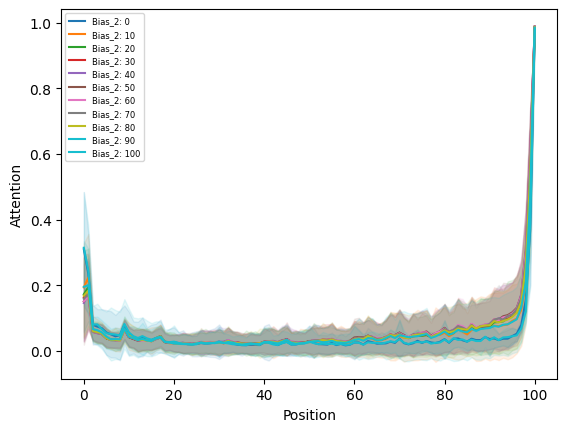

In [7]:
# Plot the attention by position
for i, bias_2 in enumerate(biases):
    att_stacked = []
    for _, cutoff in enumerate(cutoffs):
        for _, bias_1 in enumerate(biases):
            try:
                data = load_data(100, cutoff, bias_1, bias_2)
            except FileNotFoundError:
                continue

            # Get Load and normalize the attention
            for ax1 in data['all_attentions']:
                for ax2 in ax1:
                    attentions = []
                    # tokens = []
                    for att, token in zip(ax2['attention'], ax2['tokens']):
                        if token in ['Ġheads', 'Ġtails']:
                            attentions.append(att)
                            # tokens.append(token)

                    att_stacked.append(attentions)


    if att_stacked:
        att_stacked = np.array(att_stacked)
        means = np.mean(att_stacked, axis=0)
        stds = np.std(att_stacked, axis=0)

        # Get the color
        color = plt.cm.tab10(i)

        plt.plot(means, label=f'Bias_2: {bias_2}', color=color)
        plt.fill_between(range(len(means)), means - stds, means + stds, alpha=0.1, color=color)


plt.legend(fontsize=6)
plt.xlabel('Position')
plt.ylabel('Attention')
plt.show()

In [8]:
# Plot the attention by position
samples = []
for _, cutoff in enumerate(cutoffs):
    for _, bias_1 in enumerate(biases):
        for i, bias_2 in enumerate(biases):
            try:
                data = load_data(100, cutoff, bias_1, bias_2)
            except FileNotFoundError:
                continue

            # Get the pre-cutoff attention and post-cutoff attention
            pre_cutoff = []
            post_cutoff = []
            probs = []
            for ax1, p1 in zip(data['all_attentions'], data['all_probs']):
                for ax2 in ax1:
                    attentions = []
                    tokens = []
                    for att, token in zip(ax2['attention'], ax2['tokens']):
                        if token in ['Ġheads', 'Ġtails']:
                            attentions.append(att)
                            tokens.append(token)

                    pre_cutoff.append(np.mean(attentions[:cutoff]))
                    post_cutoff.append(np.mean(attentions[cutoff:]))
                    probs.append(p1['choice_probs'][0])

            samples.append((np.mean(pre_cutoff), np.mean(post_cutoff), bias_1 / 100, bias_2 / 100, cutoff, data['expected_dist'], np.mean(probs)))

print(samples[0])

(np.float64(0.12289024353027345), np.float64(0.03186923435756138), 0.0, 0.0, 10, 0.0, np.float64(0.018402862548828124))


In [9]:
# 0: Pre-cutoff attention
# 1: Post-cutoff attention
# 2: Bias_1
# 3: Bias_2
# 4: Cutoff
# 5: Expected dist
# 6: Model P(Heads)

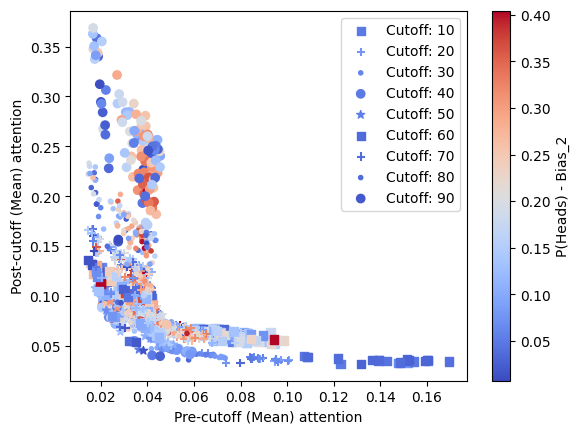

In [10]:
# Plot the deviation from bias 2 vs. pre-cutoff attention
marker = itertools.cycle((',', '+', '.', 'o', '*'))
for i, cutoff in enumerate(cutoffs):
    plt_samples = np.array([s for s in samples if s[4] == cutoff])
    if plt_samples.size > 0:
        # Set the marker based on i
        ms = next(marker)
        plt.scatter(plt_samples[:, 0], plt_samples[:, 1], c=np.abs(plt_samples[:, 6] - plt_samples[:, 3]), cmap='coolwarm', marker=ms, label=f'Cutoff: {cutoff}')


plt.xlabel('Pre-cutoff (Mean) attention')
plt.ylabel('Post-cutoff (Mean) attention')
plt.colorbar(label='P(Heads) - Bias_2')
plt.legend()
plt.show()


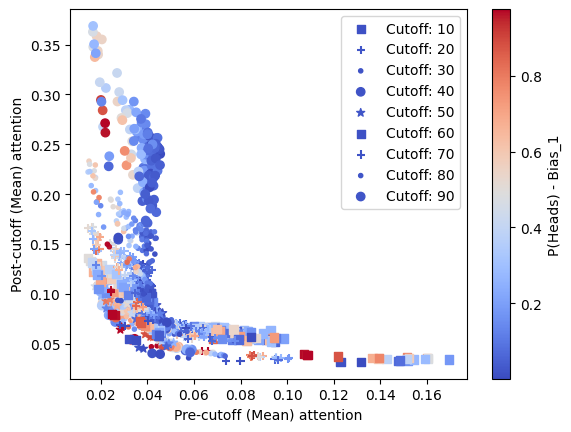

In [11]:
# Plot the deviation from bias 2 vs. pre-cutoff attention
marker = itertools.cycle((',', '+', '.', 'o', '*'))
for i, cutoff in enumerate(cutoffs):
    plt_samples = np.array([s for s in samples if s[4] == cutoff])
    if plt_samples.size > 0:
        # Set the marker based on i
        ms = next(marker)
        plt.scatter(plt_samples[:, 0], plt_samples[:, 1], c=np.abs(plt_samples[:, 6] - plt_samples[:, 2]), cmap='coolwarm', marker=ms, label=f'Cutoff: {cutoff}')


plt.xlabel('Pre-cutoff (Mean) attention')
plt.ylabel('Post-cutoff (Mean) attention')
plt.colorbar(label='P(Heads) - Bias_1')
plt.legend()
plt.show()


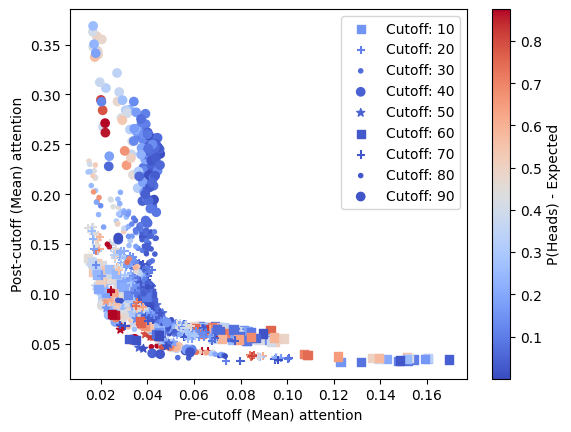

In [12]:
# Plot the deviation from bias 2 vs. pre-cutoff attention
marker = itertools.cycle((',', '+', '.', 'o', '*'))
for i, cutoff in enumerate(cutoffs):
    plt_samples = np.array([s for s in samples if s[4] == cutoff])
    if plt_samples.size > 0:
        # Set the marker based on i
        ms = next(marker)
        plt.scatter(plt_samples[:, 0], plt_samples[:, 1], c=np.abs(plt_samples[:, 6] - plt_samples[:, 5]), cmap='coolwarm', marker=ms, label=f'Cutoff: {cutoff}')


plt.xlabel('Pre-cutoff (Mean) attention')
plt.ylabel('Post-cutoff (Mean) attention')
plt.colorbar(label='P(Heads) - Expected')
plt.legend()
plt.show()


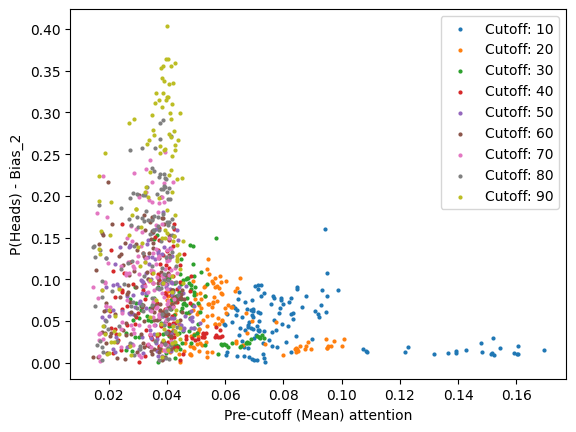

In [13]:
# Just plot pre-cutoff vs. tvd
for i, cutoff in enumerate(cutoffs):
    plt_samples = np.array([s for s in samples if s[4] == cutoff])
    if plt_samples.size > 0:
        plt.scatter(plt_samples[:, 0], np.abs(plt_samples[:, 6] - plt_samples[:, 3]), label=f'Cutoff: {cutoff}', s=4)

plt.xlabel('Pre-cutoff (Mean) attention')
plt.ylabel('P(Heads) - Bias_2')
plt.legend()
plt.show()

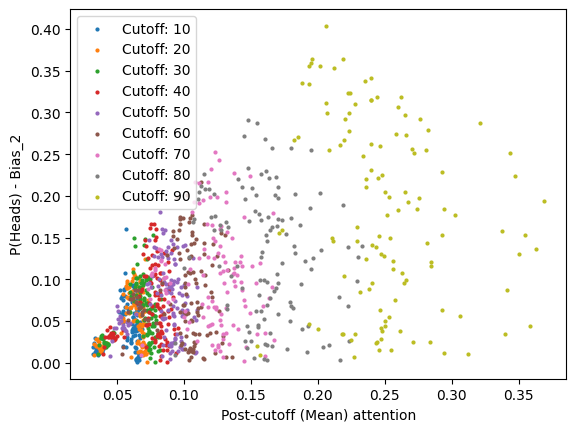

In [14]:
# Just plot post-cutoff vs. tvd
for i, cutoff in enumerate(cutoffs):
    plt_samples = np.array([s for s in samples if s[4] == cutoff])
    if plt_samples.size > 0:
        plt.scatter(plt_samples[:, 1], np.abs(plt_samples[:, 6] - plt_samples[:, 3]), label=f'Cutoff: {cutoff}', s=4)

plt.xlabel('Post-cutoff (Mean) attention')
plt.ylabel('P(Heads) - Bias_2')
plt.legend()
plt.show()

In [15]:
# Plot the attention by position
samples = []
for _, cutoff in enumerate(cutoffs):
    for _, bias_1 in enumerate(biases):
        for i, bias_2 in enumerate(biases):
            try:
                data = load_data(100, cutoff, bias_1, bias_2)
            except FileNotFoundError:
                continue

            # Get the pre-cutoff attention and post-cutoff attention
            pre_cutoff = []
            post_cutoff = []
            probs = []
            for ax1, p1 in zip(data['all_attentions'], data['all_probs']):
                for ax2 in ax1:
                    attentions = []
                    tokens = []
                    for att, token in zip(ax2['attention'], ax2['tokens']):
                        if token in ['Ġheads', 'Ġtails']:
                            attentions.append(att)
                            tokens.append(token)

                    pre_cutoff.append(np.sum(attentions[:cutoff]))
                    post_cutoff.append(np.sum(attentions[cutoff:]))
                    probs.append(p1['choice_probs'][0])


            samples.append((np.mean(pre_cutoff), np.mean(post_cutoff), bias_1 / 100, bias_2 / 100, cutoff, data['expected_dist'], np.mean(probs)))


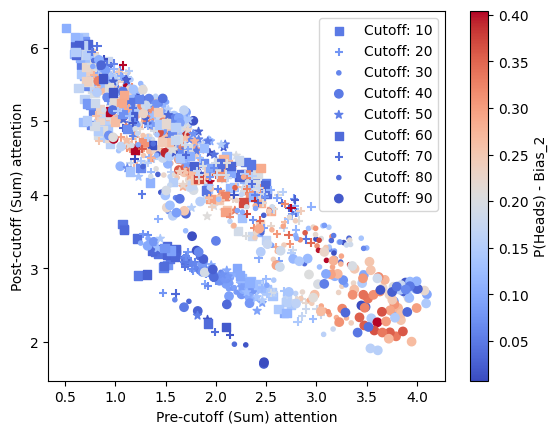

In [16]:
# Plot the deviation from bias 2 vs. pre-cutoff attention
marker = itertools.cycle((',', '+', '.', 'o', '*'))
for i, cutoff in enumerate(cutoffs):
    plt_samples = np.array([s for s in samples if s[4] == cutoff])
    if plt_samples.size > 0:
        # Set the marker based on i
        ms = next(marker)
        plt.scatter(plt_samples[:, 0], plt_samples[:, 1], c=np.abs(plt_samples[:, 6] - plt_samples[:, 3]), cmap='coolwarm', marker=ms, label=f'Cutoff: {cutoff}')


plt.xlabel('Pre-cutoff (Sum) attention')
plt.ylabel('Post-cutoff (Sum) attention')
plt.colorbar(label='P(Heads) - Bias_2')
plt.legend()
plt.show()

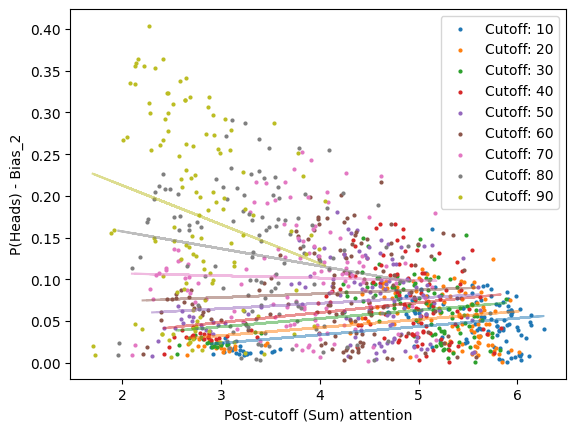

In [17]:
# Just plot post-cutoff vs. tvd
for i, cutoff in enumerate(cutoffs):
    plt_samples = np.array([s for s in samples if s[4] == cutoff])
    if plt_samples.size > 0:
        plt.scatter(plt_samples[:, 1], np.abs(plt_samples[:, 6] - plt_samples[:, 3]), label=f'Cutoff: {cutoff}', s=4)
        # Plot the line of best fit
        z = np.polyfit(plt_samples[:, 1], np.abs(plt_samples[:, 6] - plt_samples[:, 3]), 1)
        p = np.poly1d(z)
        plt.plot(plt_samples[:, 1], p(plt_samples[:, 1]), alpha=0.5)


plt.xlabel('Post-cutoff (Sum) attention')
plt.ylabel('P(Heads) - Bias_2')
plt.legend()
plt.show()

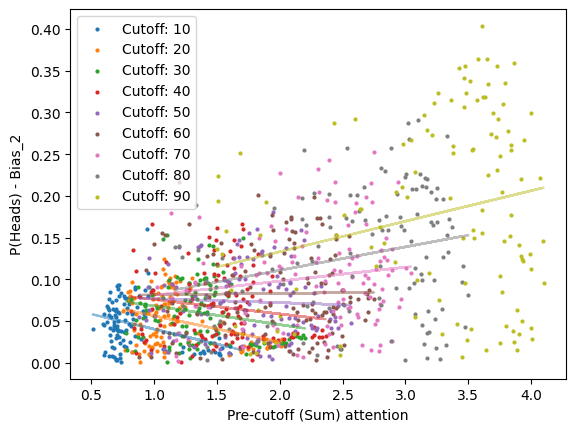

In [18]:
# Just plot pre-cutoff vs. tvd
for i, cutoff in enumerate(cutoffs):
    plt_samples = np.array([s for s in samples if s[4] == cutoff])
    if plt_samples.size > 0:
        plt.scatter(plt_samples[:, 0], np.abs(plt_samples[:, 6] - plt_samples[:, 3]), label=f'Cutoff: {cutoff}', s=4)
        # Plot the line of best fit
        z = np.polyfit(plt_samples[:, 0], np.abs(plt_samples[:, 6] - plt_samples[:, 3]), 1)
        p = np.poly1d(z)
        plt.plot(plt_samples[:, 0], p(plt_samples[:, 0]), alpha=0.5)


plt.xlabel('Pre-cutoff (Sum) attention')
plt.ylabel('P(Heads) - Bias_2')
plt.legend()
plt.show()

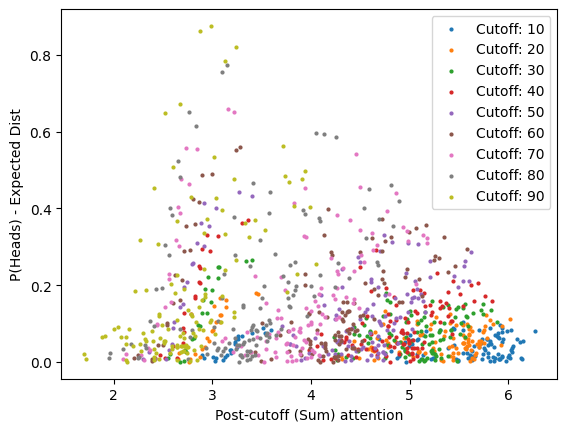

In [19]:
# Just plot post-cutoff vs. expected dist tvd
for i, cutoff in enumerate(cutoffs):
    plt_samples = np.array([s for s in samples if s[4] == cutoff])
    if plt_samples.size > 0:
        plt.scatter(plt_samples[:, 1], np.abs(plt_samples[:, 6] - plt_samples[:, 5]), label=f'Cutoff: {cutoff}', s=4)



plt.xlabel('Post-cutoff (Sum) attention')
plt.ylabel('P(Heads) - Expected Dist')
plt.legend()
plt.show()

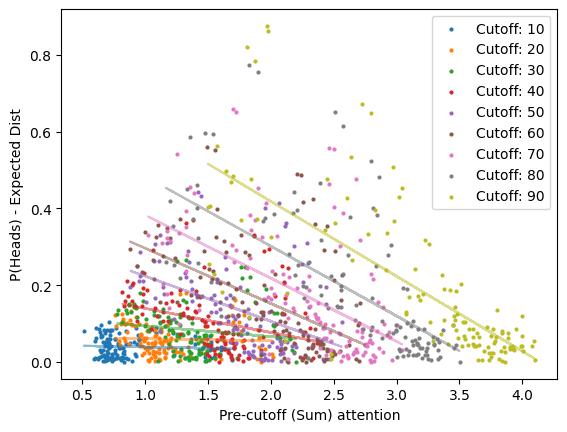

In [20]:
# Just plot pre-cutoff vs. expected dist tvd
for i, cutoff in enumerate(cutoffs):
    plt_samples = np.array([s for s in samples if s[4] == cutoff])
    if plt_samples.size > 0:
        plt.scatter(plt_samples[:, 0], np.abs(plt_samples[:, 6] - plt_samples[:, 5]), label=f'Cutoff: {cutoff}', s=4)
        # Line of best fit
        z = np.polyfit(plt_samples[:, 0], np.abs(plt_samples[:, 6] - plt_samples[:, 5]), 1)
        p = np.poly1d(z)
        plt.plot(plt_samples[:, 0], p(plt_samples[:, 0]), alpha=0.5)



plt.xlabel('Pre-cutoff (Sum) attention')
plt.ylabel('P(Heads) - Expected Dist')
plt.legend()
plt.show()

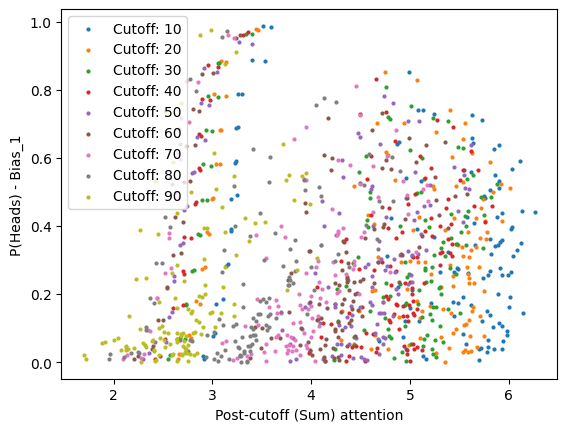

In [21]:
# Just plot post-cutoff vs. tvd
for i, cutoff in enumerate(cutoffs):
    plt_samples = np.array([s for s in samples if s[4] == cutoff])
    if plt_samples.size > 0:
        plt.scatter(plt_samples[:, 1], np.abs(plt_samples[:, 6] - plt_samples[:, 2]), label=f'Cutoff: {cutoff}', s=4)
        # Plot the line of best fit
        # z = np.polyfit(plt_samples[:, 1], np.abs(plt_samples[:, 6] - plt_samples[:, 2]), 1)
        # p = np.poly1d(z)
        # plt.plot(plt_samples[:, 1], p(plt_samples[:, 1]), alpha=0.5)


plt.xlabel('Post-cutoff (Sum) attention')
plt.ylabel('P(Heads) - Bias_1')
plt.legend()
plt.show()

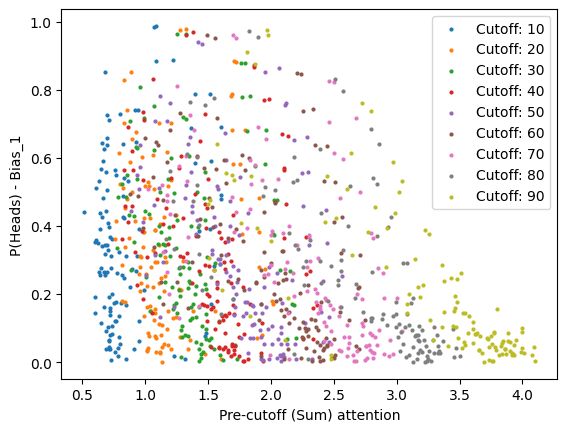

In [22]:
# Just plot post-cutoff vs. tvd
for i, cutoff in enumerate(cutoffs):
    plt_samples = np.array([s for s in samples if s[4] == cutoff])
    if plt_samples.size > 0:
        plt.scatter(plt_samples[:, 0], np.abs(plt_samples[:, 6] - plt_samples[:, 2]), label=f'Cutoff: {cutoff}', s=4)
        # Plot the line of best fit
        # z = np.polyfit(plt_samples[:, 1], np.abs(plt_samples[:, 6] - plt_samples[:, 2]), 1)
        # p = np.poly1d(z)
        # plt.plot(plt_samples[:, 1], p(plt_samples[:, 1]), alpha=0.5)


plt.xlabel('Pre-cutoff (Sum) attention')
plt.ylabel('P(Heads) - Bias_1')
plt.legend()
plt.show()

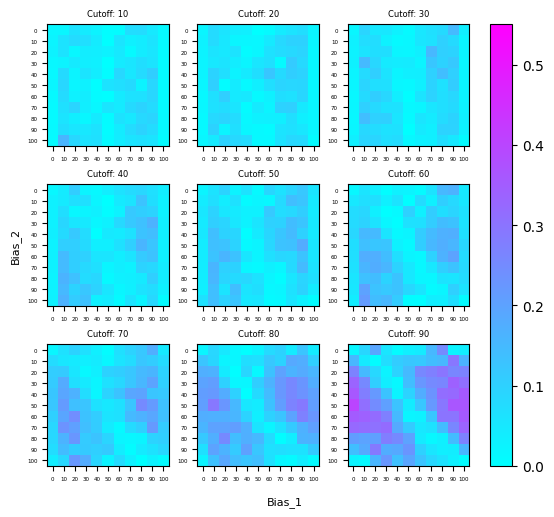

In [23]:
# For each cutoff, plot the bias_1 vs. bias_2 vs. TVD

# Put the cutoffs in sub-plots
fig, axs = plt.subplots(3, 3, layout='compressed')

cmap = plt.cm.cool
cmap.set_under(color='black')

for i, cutoff in enumerate(cutoffs):
    plt_samples = np.array([s for s in samples if s[4] == cutoff])
    data = np.zeros((len(biases), len(biases))) - 1
    for s in plt_samples:
        data[int(s[2] * 10), int(s[3] * 10)] = np.abs(s[6] - s[3])

    ax = axs[i // 3, i % 3]
    im = ax.imshow(data, cmap=cmap, vmin=0, vmax=0.55)
    ax.set_title(f'Cutoff: {cutoff}', fontsize=6)
    ax.set_xticks(np.arange(len(biases)), labels=[f'{b}' for b in biases], fontsize=4)
    ax.set_yticks(np.arange(len(biases)), labels=[f'{b}' for b in biases], fontsize=4)

fig.colorbar(im, ax=axs.ravel().tolist())
fig.text(0.5, -0.04, 'Bias_1', ha='center', fontsize=8)
fig.text(0.07, 0.5, 'Bias_2', va='center', rotation='vertical', fontsize=8)
plt.show()
